# Transformers - Attention is All You Need
Welcome to the captivating world of Transformers in Natural Language Processing (NLP)! In recent years, Transformers have emerged as a groundbreaking paradigm in NLP, revolutionizing how we comprehend and process language. Unlike older architectures such as LSTMs (Long Short-Term Memory) and CNNs (Convolutional Neural Networks), Transformers leverage self-attention mechanisms, enabling them to capture long-range dependencies more effectively and allowing for parallelization of computations. The seminal paper ['Attention Is All You Need'](https://arxiv.org/abs/1706.03762) introduced the Transformer model, showcasing its prowess in various language tasks and laying the foundation for its widespread adoption. This Jupyter notebook is designed to unravel the intricacies of Transformers, highlighting their architectural nuances, contrasting them with traditional models, and demonstrating their applications across diverse NLP domains! (And in case you were wondering - yes, a certain transformer model created this text :D)

We will stick very closely to the implementation presented in the paper to build our own translation model! There is no need to read it though, you can find the necessary sections of the paper before each task, together with some explanations. 

Alright - let's do this!

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [ ]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_11) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_11'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

In [1]:
from exercise_code.util import notebook_util as util
from exercise_code.network.Transformer import *
from exercise_code.tests import *
from exercise_code.Trainer import MPS_AVAILABLE
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

root_path = os.path.dirname(os.path.abspath(os.getcwd()))
model_path = os.path.join(os.getcwd(), 'models')
submission_path = os.path.join(os.getcwd(), 'submission_files')
pretrained_model_path = os.path.join(model_path, 'pretrainedModels')
dataset_path = os.path.join(root_path, 'datasets', 'transformerDatasets')

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/anar/anaconda3/envs/i2dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Overview

<!-- <img src="images/Transformer-Transformer.drawio.png" width="2500"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Transformer.drawio.png"  width="2500">




The model consists of two bigger building blocks, the encoder and the decoder. The encoder processes the input to our model. In our translation model, this input would be the sentence in the source language. The decoder part iteratively produces an output sequence. As an input it takes the already predicted words and given that sequence and the encoder input, it produces an output sequence as follows:

| Encoder Input                       | Decoder Input                                      | Decoder Output                                   |
|-------------------------------------|----------------------------------------------------|--------------------------------------------------|
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>"]                                       | ["Hallo"]                                        |
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>", "Hallo"]                              | ["Hallo", "wie"]                                 |
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>", "Hallo", "wie"]                       | ["Hallo", "wie", "geht's"]                       |
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>", "Hallo", "wie", "geht's"]             | ["Hallo", "wie", "geht's", "dir"]                |
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>", "Hallo", "wie", "geht's", "dir"]      | ["Hallo", "wie", "geht's", "dir", "?"]           |
| ["Hello" ,"how", "are", "you", "?"] | ["\<start>", "Hallo", "wie", "geht's", "dir", "?"] | ["Hallo", "wie", "geht's", "dir", "?", "\<end>"] |

And the predicted end token breaks the loop.

# Embedding Layer

Let's discuss the input to our model first: So far, with images, its quite clear that similar values on a pixel level correspond to somewhat similar images. Now, how about text?

As discussed in the tokenizer notebook, our words or sub-words that make up a sentence are transformed into individual IDs.
Imagine what would happen if we used these token IDs directly as an input to the neural network: Each input neuron would be activated proportionally to the ID of the token. This would mean that the model would assume that the tokens with similar IDs are somehow more related and that the distance between the token IDs is meaningful. This is, of course, not the case! "House" might have ID 627 and "Bungalow" might be ID 9384, even though they mean similar things and a classifier should be able to classify both words as buildings. Remember that during the training of the tokenizer, we didn't care much about the words semantics, only about the frequency!

Ideally, we would like to represent our words in a way that similar meanings have similar values. This is where **embeddings** come in:
Embeddings are vector representations of our tokens, so that tokens with similar meanings have similar vectors, i.e. closer together in the vector space (called **embedding space**).

Let's look at some simple examples! First, the tokens with their raw IDs:

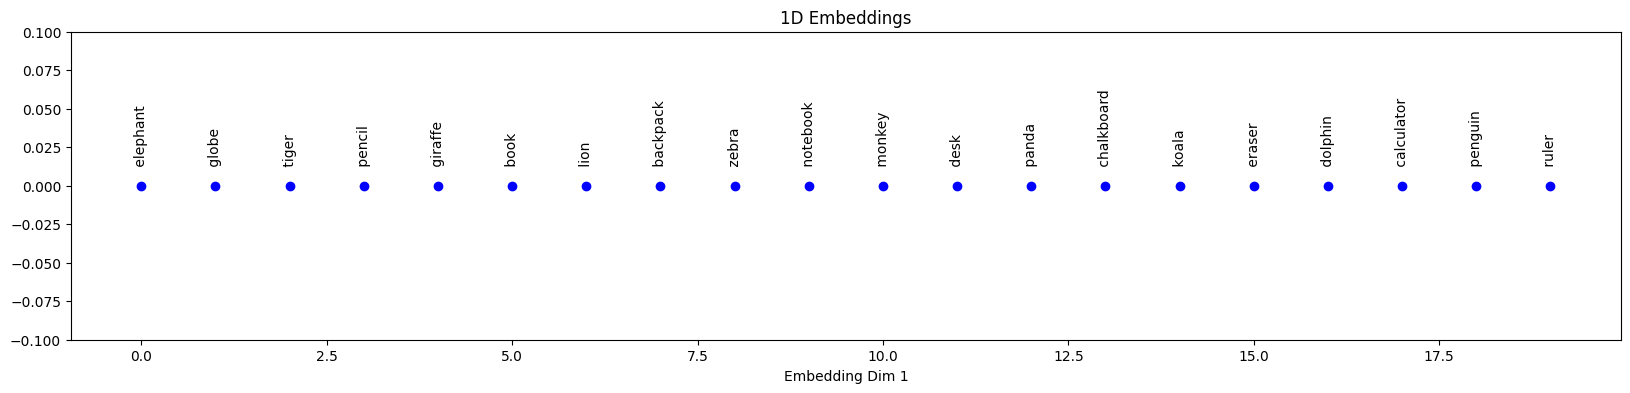

In [2]:
labels, embeddings = util.create_embeddings(1, token_id=True)
util.plot_embeddings(labels, embeddings)

So the first idea you might have is to reorder the IDs and to group similar words together, assuming we could somehow "measure" similarity between two words! Let's have a look at what this could look like:

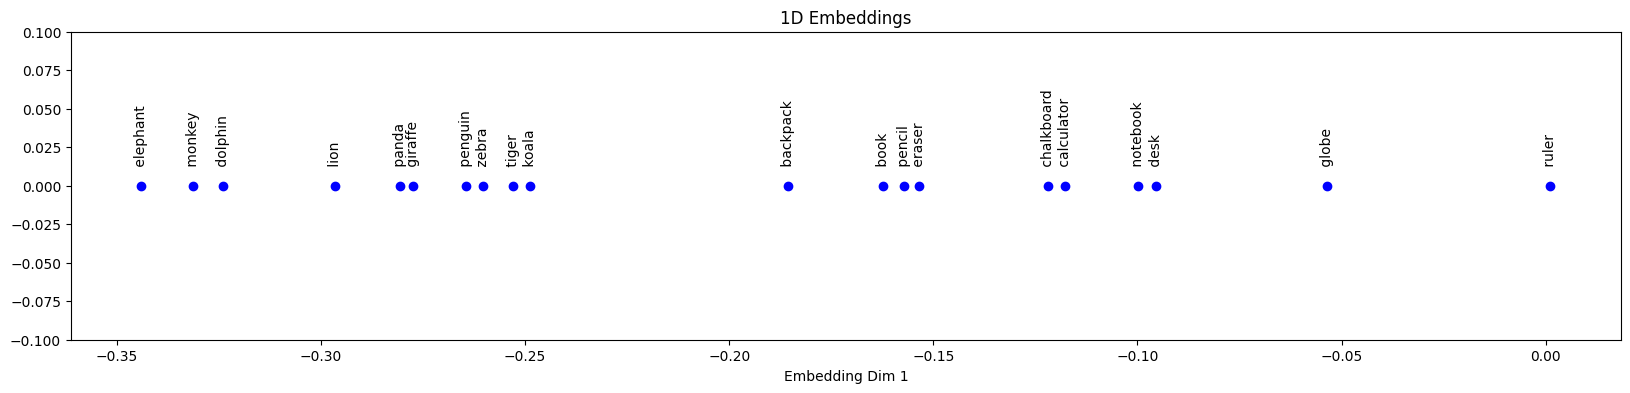

In [3]:
labels, embeddings = util.create_embeddings(1)
util.plot_embeddings(labels, embeddings)

Even with this relatively simple algorithm, we can already see certain groups form. On the right we have school related words, on the left we have animals. 

What we have actually just created are basically 1D Embeddings!

However, with 1D Embeddings we can't really encode more complicated relationships, like for example a triangle relationship, where three words are all equally similar to each other. By adding dimensions to our embedding, we can see more complex connections between word pairs. In 2D this could look like this:

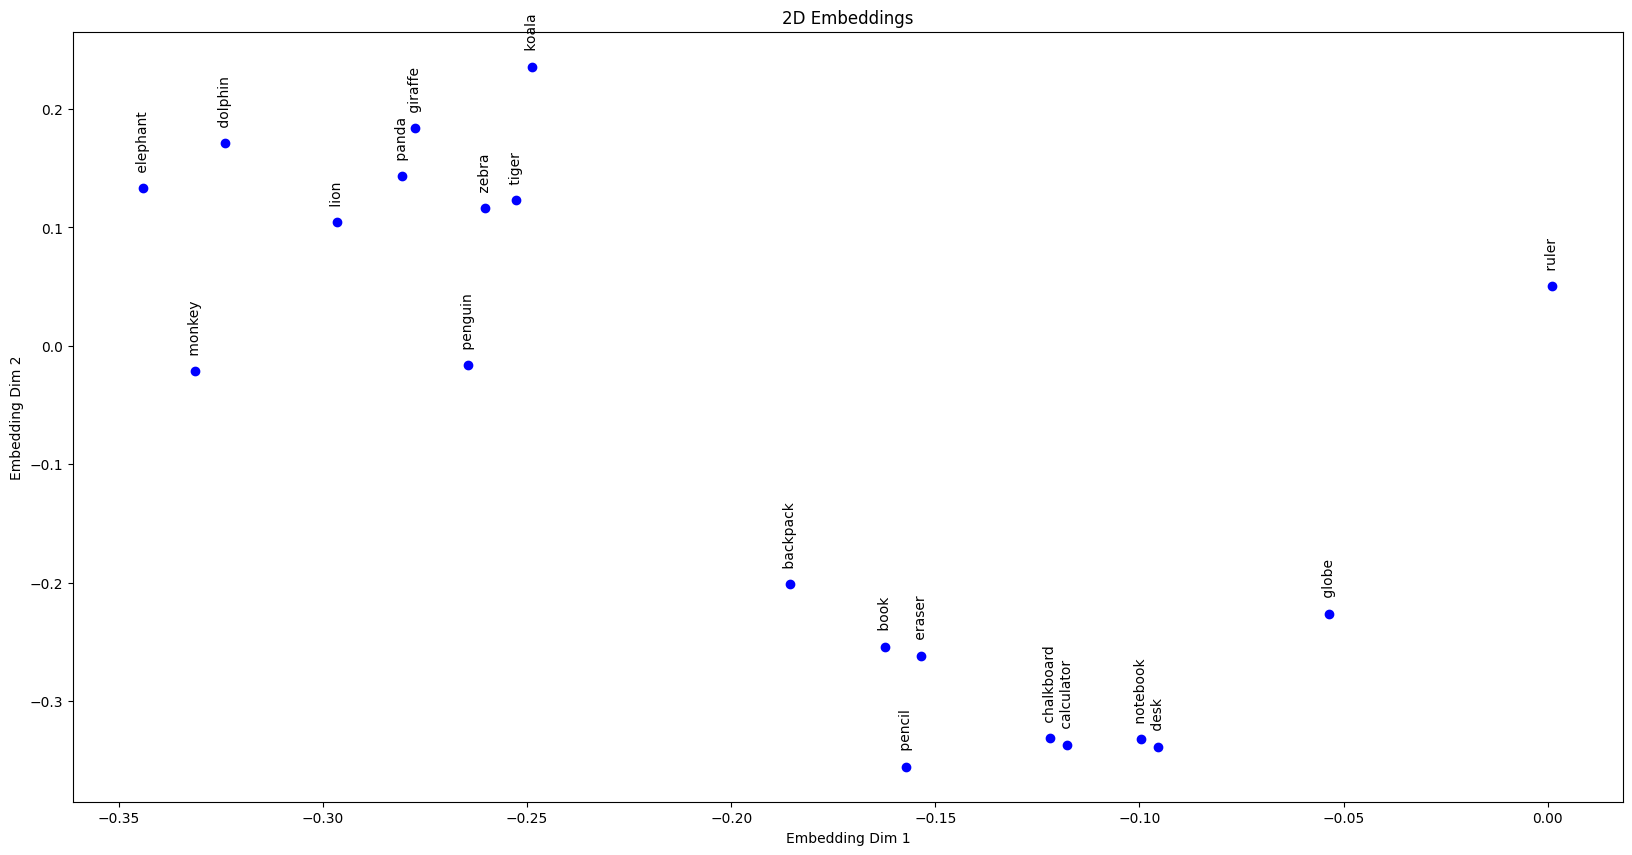

In [4]:
labels, embeddings = util.create_embeddings(2)
util.plot_embeddings(labels, embeddings)

In our transformer model, we will actually create an embedding with 512 dimensions! And we won't even have to define a similarity function between words, during training the model will decide on its own where to place words in the embedding space!

At the end of the day, the embedding layer is a simple lookup table that maps each token ID to these embedding vectors.

If you are more interested in Embeddings, go check out this awesome tool, that let's you play around with word embeddings: http://vectors.nlpl.eu/explore/embeddings/en/

Also, Computerphile made a nice video on vector embeddings, you can find it here: https://www.youtube.com/watch?v=gQddtTdmG_8

<div class="alert alert-warning">
    <h3>WARNING: Task Implementation</h3>
    <p>Throughout this notebook you will as always have to complete several tasks to complete the individual modules! Please be aware though, that some Modules may have several tasks that have to be completed, but please <strong>only</strong> concentrate on the <strong>current task</strong> and the <strong>corresponding hints</strong> (if there are any;). In other words, if you are working on Task 1, and there is also Task 4 in the TODOs of that Module, you don't have to work on it at this moment! <br>
    Also, if we mention any specific pytorch modules in the task description or hints, you <strong>are allowed to use them!</strong> With that said, let's work on your first task!
    </p>
</div>

<div class="alert alert-info">
    <h3>Task 1: Implement</h3>
    <p>Implement the class <code>Embedding</code> in <code>exercise_code/network/Transformer.py</code>.
    </p>
</div>

In [25]:
_ = test_task_1()


####### Testing Started #######

Test EmbeddingShapeTest: passed!
Test EmbeddingForwardShapeTest: passed!

####### Testing Finished #######
Test TestTask1: passed! -->  Tests passed: 2/2
Score: 100/100


We will be adding another feature to the embedding layer later in the notebook, however to understand the need for it we have to explain the attention mechanism first! </br>
So far, our Embedding Layer looks somewhat like this: 

<!-- <img src="images/Transformer-Embedding.drawio.png" width="1000"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Embedding.drawio.png" width="1000">



## Attention Mechanism

### Improving Noisy Measurements
Imagine you have taken some measurement x(t), but notice that it is quite noisy:

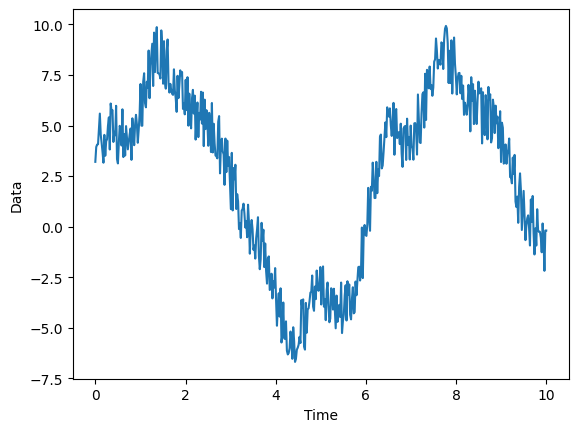

In [26]:
measurement_data = util.get_measurement_data()
plt.plot(measurement_data['time'], measurement_data['data_noise'])
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

So a way we could try to improve these measurements is by averaging out the values using a weighted average:


$\tilde{x}_i = \sum_{j=1}^N s_{ij} x_j$

We could base the weights on a similarity score between the time stamps. Values that are closer together time-wise, should have a larger impact/weight compared to values that are further apart!

$s_{ij} = sim(t_i, t_j)$

A possible option as a similarity function is the squared exponential kernel:

$sim(t_i, t_j) = \exp\left(-\frac{(t_i - t_j)^2}{\sigma ^2}\right)$

Let's have a look at the similarity function:

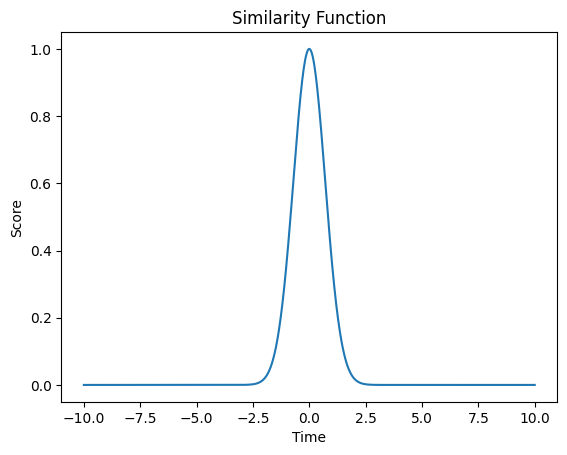

In [27]:
# Define the squared exponential kernel 
def similarity(x1, x2):
    sigma = 1
    return np.exp(-((x1 - x2)**2 / (sigma ** 2)))

# Define the time stamps
time_stamps = np.linspace(-10, 10, 1000)

# Compute the similarity scores between 0 and all other time stamps
scores = similarity(0, time_stamps)

# Plot the similarity scores
plt.plot(time_stamps, scores)
plt.title('Similarity Function')
plt.xlabel('Time'), plt.ylabel('Score')
plt.show()

As you can see, the closer we get to the zero, the higher the score gets!
And now let's plot the actual score matrix!

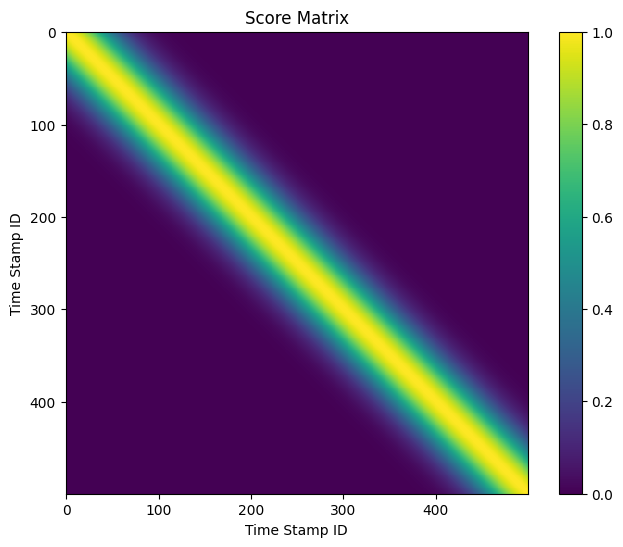

In [28]:
# Get the actual timestamps from the measurement data
time_stamps = measurement_data['time']

# Compute the similarity scores between all time stamps
scores = similarity(time_stamps[:, None], time_stamps[None, :])

# Plot the similarity scores
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest')
plt.title('Score Matrix')
plt.colorbar()
plt.xlabel('Time Stamp ID'), plt.ylabel('Time Stamp ID')
plt.show()

What you should see a high value along the diagonal, and the values decrease the further you move away from the diagonal. 

Next, let's compute these averages! Note, that the average can also be described as a Matrix-Vector product:

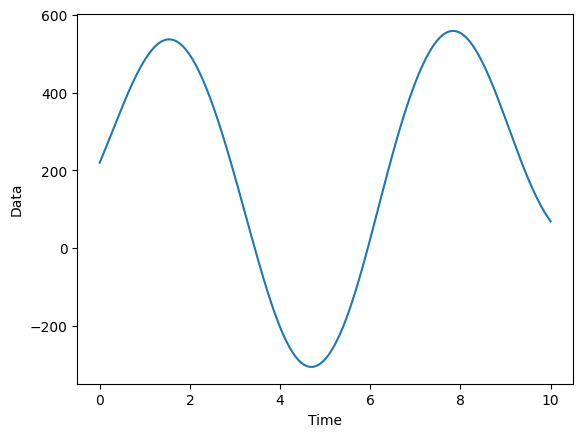

In [29]:
# Compute filtered data
filter_data = scores @ measurement_data['data_noise']

# Plot the filtered data
plt.plot(time_stamps, filter_data)
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

Looks a lot better! However, we are actually filtering out a lot of the underlying signal. Try changing sigma in the next cell to a different values (e.g $\sigma = 0.5$ or even $\sigma = 0.1$) and have a look at the function!

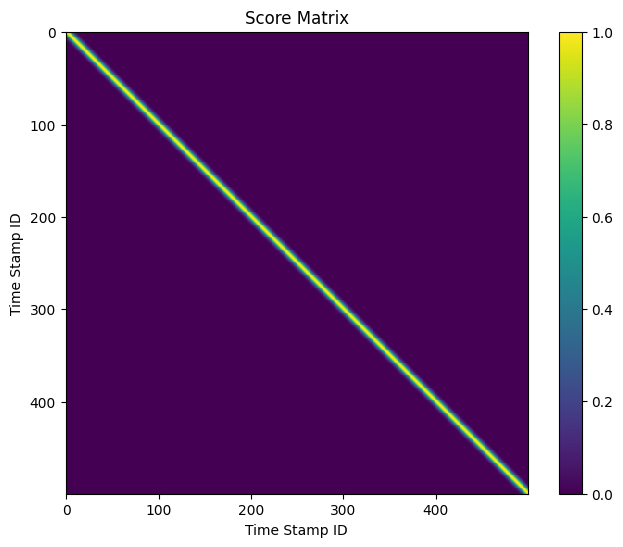

In [37]:
# Edit Sigma here
sigma = 0.1

def similarity(x1, x2):
    return np.exp(-((x1 - x2)**2 / (sigma ** 2)))

# Compute the similarity scores between all time stamps
scores = similarity(time_stamps[:, None], time_stamps[None, :])

# Plot the similarity scores
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest')
plt.title('Score Matrix')
plt.colorbar()
plt.xlabel('Time Stamp ID'), plt.ylabel('Time Stamp ID')
plt.show()

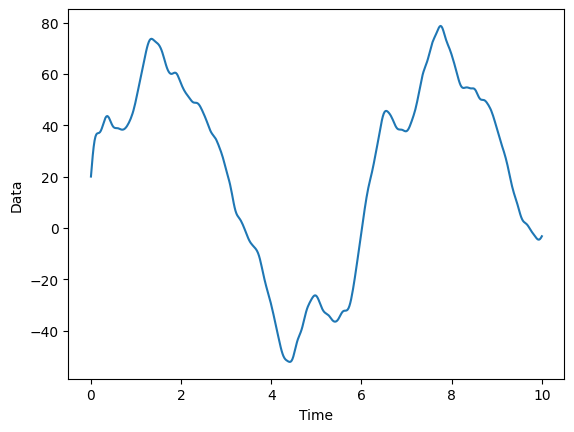

In [38]:
# Compute filtered data
filter_data = scores @ measurement_data['data_noise']

# Plot the filtered data
plt.plot(time_stamps, filter_data)
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

If you did it then - Nice! We are not loosing that much information anymore! If not - Come on, it's like only one line ;P

We still have one problem in our implementation: If you have a look at the scale of our data, it has changed quite a bit!

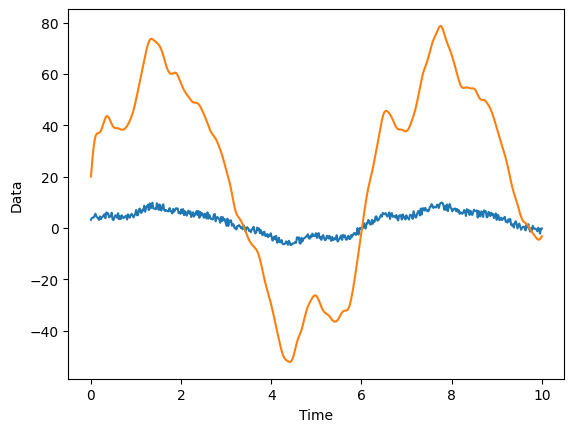

In [39]:
# Plot filtered data and the original measurement data
plt.figure()
plt.plot(time_stamps, measurement_data['data_noise'])
plt.plot(time_stamps, filter_data)
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

We can somewhat improve this by normalizing our scores to sum up to one.

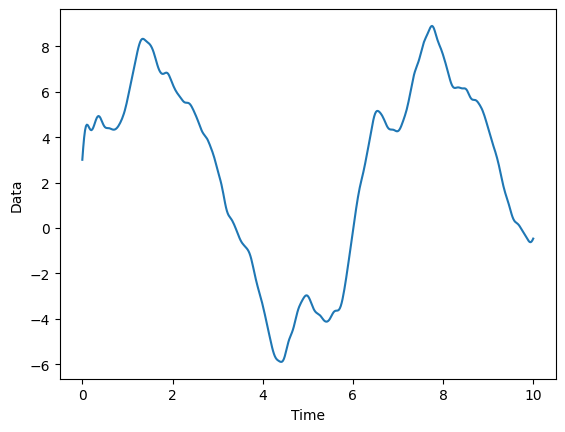

In [40]:
# Normaliize scores by dividing by the sum of all scores
scores_normalized = scores / np.sum(scores, axis=0)

# Calculate the filtered data again using the normalized weights
filter_data = scores_normalized @ measurement_data['data_noise']

# Plot the filtered data
plt.plot(time_stamps, filter_data)
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

Now the scales should match a lot better!

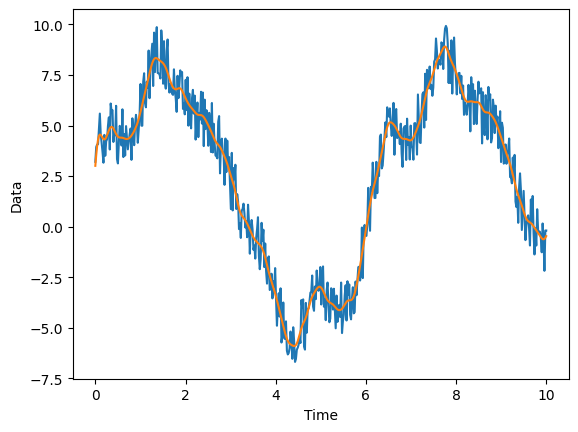

In [41]:
# Plot filtered data with normalized scores and the original measurement data
plt.figure()
plt.plot(time_stamps, measurement_data['data_noise'])
plt.plot(time_stamps, filter_data)
plt.xlabel('Time'), plt.ylabel('Data')
plt.show()

Another way of thinking about this, is that we have "improved" our data, by introducing context from other points to it, i.e. each datapoint looks at its neighboring datapoints. We can also introduce the terminology used in the paper: For every **query** (timestamp) $t_i$, compare it to all available **keys** $t_j$ (all other timestamps) and compute **similarity scores**. Multiply these scores with the corresponding **values** $x_j$ (the measurements) to form the "answer" to the query $t_i$. Note, that each key corresponds to a value!

Now let's see if we can find something similar for words. After all, thats what we want our model to work with.

### Applying Similarity-based Context to Word Embeddings

The concept of attention mirrors the method we used earlier:

When we transform a sentence into a sequence of embeddings $x_i$, translating each word independently may cause an issue: context matters!

Consider these sentences:
- The river bank is very long.
- The bank is located at the long river.

Both contain the word 'bank', but its meaning changes with context. Think about what this also means for the embeddings, which are supposed to "capture the meaning" of each word: The embedding for 'bank' should ideally differ in both sentences!

Our current implementation of the embedding layer does not take context (i.e. the other words in the sentence) into account, it simply maps each word to a vector from a static lookup table. Therefore, we need to find a way to **contextualize** the embeddings!

The simplest way to create contextualized embeddings, similar to before, is to take a weighted average of the embeddings of all words we want to get context from - our values $x_j$:

$\tilde{x}_i = \sum_{j=1}^N s_{ij} x_j$

We define the scores as before, but now, we calculate similarity between the embeddings themselves! And just like in the noisy measurements, we compute the similarity between the query $x_i$ and the keys $x_j$: 

$s_{ij} = \text{sim}(x_i, x_j)$

Does this make sense? The learned embeddings ideally represent similar words that co-occur or are semantically linked (like 'apple' and 'fruit'). Conversely, words with low co-occurrence, like 'computer' and 'elephant', should be dissimilar. So in way it does make sense, that "similar" words should contribute more to each other's context (but we will revisit this later).

Now, about the similarity function: instead of the squared exponential kernel, we use the dot product! But does the dot product truly measure similarity between vectors?

$\langle a,b \rangle = \cos(\angle_{ab})|a||b|$

We can see from here, that the closer two embeddings are, the higher the dot product will become! (Of course the norm of the vectors also affects the score)

Let's define the similarity function:

In [42]:
# Define similarity function as the inner product
def similarity(x1, x2):
    return np.inner(x1, x2)

We have prepared a pretrained embedding model for you, so you can play around with it!

In [43]:
# Load the word2vec model
word2vec = util.load_word2vec()

In [44]:
# Get the word vectors for apple and fruit
word_1 = word2vec['apple']
word_2 = word2vec['fruit']

# Compute the similarity between apple and fruit
similarity(word_1, word_2)

17.202904784140003

Ok, and now for a reference, let's look at two words that should not be related to much!

In [45]:
word_1 = word2vec['computer']
word_2 = word2vec['elephant']

similarity(word_1, word_2)

2.7030388269099985

Ok, so we now what we have to do: Compute the similiarity scores to each key, and form the answer to our query. Here is a visualualization showing this flow: 
<!-- <img src="images/Transformer-AttentionMechanism.drawio.png" width=2000> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-AttentionMechanism.drawio.png" width=2000>


Now let's do this in code!

In [46]:
# Create an example sentence
sentence = "The river bank is very long"

# Get the word vectors for the words in the sentence
embeddings, words = util.embedd_sentence(sentence)

In [56]:
print(words[0])

50


For now, we will set the queries, keys and values to be the same! 

In [47]:
query = embeddings
keys = embeddings
values = embeddings

Instead of calculating the score for each query separately, we can use matrix multiplication to calculate all the dot products between the query and keys in one go:

$s_{ij} = q_i^T k_j$ or in matrix notation $S = QK^T$  

This obviously only works if the matrices are oriented in the correct way! But we will be using the same format as we have been so far - each row is a sample (or in this case an embedded word)

In [48]:
scores = query @ keys.T

Similar to the example with the timeseries, we want to make sure that the scores that correspond to a query all add to up one! We will be using the softmax in this case to ensure positive scores as well:

In [49]:
scores = util.softmax(scores)

The final step is contextualizing the embeddings by summing over all values, weighted by the scores! 

In [50]:
contextualized_embeddings = scores @ values 

And voila, thats basically all there is to the attention mechanism! If we look at the formula in the paper you will find

$Attention(Q,K,V) = softmax\left(\frac{QK^T}{\sqrt{d_k}}\right) V$

The value $d_k$ corresponds to the dimension of the keys and scales the dot product results. It is added to keep the dot product from growing, when the embedding dimensions is increased. (If you increase the dimension, you also increase the number of elements you have to add together!) However, larger values of the dot products push the softmax function into regions with smaller gradients, which can slow down training significantly. 

<!-- <img src="images/Transformer-Attention Head.drawio.png" width="2000"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-AttentionHead.drawio.png" width=2000>


<div class="alert alert-info">
    <h3>Task 2: Implement</h3>
    <p>Implement the <code>forward</code> pass in the class <code>ScaledDotAttention</code>. You can find it in <code>exercise_code/networks/Transformer.py</code>!
    </p>
</div>

In [ ]:
# If you get an Error about SCORE_SAVER - please just restart your kernel!
_ = test_task_2()

## Multi-Head Attention

So far, we are able to give context to an input sequence - awesome! However, what each token needs to "pay attention to" in its context is a bit more complicated! We can imagine, for example, that a verb might need to pay more attention to the subject and object of the sentence, or in the case of the word "bank", it might need to pay more attention to the word "river" or "money" to figure out its own intended meaning. And since language is so complex, you can imagine that there are so many different aspects that each token needs to pay attention to! This is where the idea of multi-head attention comes in:

Instead of just using the embeddings directly, we can use linear transformations to down-project into more *fine-grained* queries $QW^Q$, keys $KW^K$ and values $VW^V$ from the embeddings. This way, the model can learn which aspects of the embeddings are important! We call this one "unit" of attention mechanism an **attention head**:

$head(Q, K, V) = Attention(QW^Q, KW^K, VW^V)$

And as the headline suggests, we can create multiple heads with their own weights and concatenate them together. This is very similar to a convolution layer with multiple filters in images! Each filter can learn different patterns in the image, and each head can learn different aspects to focus more attention to.

Once all these heads are evaluated and concatenated, we have to somehow combine them together to retain the original shape of the input! This is done with a linear layer $W^O$:

$MultiHead(Q, K, V) = Concat(head_1, ..., head_{n_{heads}})W^O$ where $head_i(Q, K, V) = Attention(QW_i^Q, KW_i^K, VW_i^V)$

Finally, let's check the dimensions of the weights, where $d_{model}$ is the dimension of the embeddings:

$shape(W^Q_i) = (d_{model},\, d_q) = (d_{model},\, d_k) $     Since we are computing dot products between the query vectors and the keys, the dimensions have to match!  
$shape(W^K_i) = (d_{model},\, d_k)$  
$shape(W^V_i) = (d_{model},\, d_v)$  
$shape(W^O) = (d_v*n_{heads},\, d_{model})$

<!-- <img src="images/Transformer-Multi Head Attention.drawio.png" width=800> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-MultiHeadAttention.drawio.png" width=800>


In our implementation, we are going to vectorize this expressions by creating three large weight matrices instead of a set for each head:

$shape(W^Q) = (d_{model},\, n_{heads} * d_k)$       
$shape(W^K) = (d_{model},\, n_{heads} * d_k)$  
$shape(W^V) = (d_{model},\, n_{heads} * d_v)$  

That way we don't have to loop through the heads in python! Now we have to reshape the outputs and get them into the correct shape! Let's have a look at one example:

$shape(Q*W^Q) = (seq_Q, d_{model}) * (d_{model},\, n_{heads} * d_k) = (seq_Q,\, n_{heads} * d_k)$ where $seq_Q$ is the sequence length of the queries

Now we have to split the last dimension into two parts - $n_{heads}$ and  $d_k$. We can do this using torch.reshape!:

$(seq_Q,\, n_{heads} * d_k)$ -> $(seq_Q,\, n_{heads}, d_k)$

Now if we look at the last two dimensions, we actually expect it to be $seq_Q$ and $d_k$, so that we can run it through the attention block! 

In other words, we have to swap (or should say transpose) the the tensor at the correct dimension:

$(seq_Q,\, n_{heads}, d_k)$ -> $(n_{heads}, seq_Q,\, d_k)$

And now we can feed this into our attention mechanism as we usually do, think of it as a batch of batches. The pytorch functions automatically handle this for us! 

<div class="alert alert-info">
    <h3>Task 3: Implement</h3>
    <p>Implement the <code>__init__()</code> method and the <code>forward()</code> method of the <code>MultiHeadAttention</code> class in <code>exercise_code/network/Transformer.py</code>. 
    </p>
</div>

In [ ]:
_ = test_task_3()

# Cross Attention vs Self Attention

You might have noticed, that we are always talking about inputs to an attention mechanism and the context we want to compare it to. If we use the terminology from the paper, our inputs form the query of our attention mechanism, and the context forms the key - value pairs! 

## Cross Attention
Cross-Attention might be the easier idea to understand. We use two different sources for the input and context! In the transformer model, this type of attention will be used in the decoder, that way we can contextualize our output with the actual input to our model. 

Let's say you ask the model a question like "Hello, how are you?". This will be processed by the encoder and it will give us some output. Next, the decoder will start to produce its output token by token, and at each step, the output should obviously depend on our initial question! We can achieve this by using cross attention, where the inputs to the mechanism come from the decoder itself, and the context comes from the encoder. Is is trying to give context from our input to its output - something we definetly want to have!

## Self Attention
In Self-Attention, the input and the context source are the same! That means, every word in a sequence is attending to all words in the same sequence, or in other words - the sentence is attending to itself. This form is used in both the encoder and decoder, and is used to process their inputs to gain a "deeper" understanding of the inputs by giving them context.

<!-- <img src="images/Transformer-Self Cross Attention.drawio.png" width=2000> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-SelfCrossAttention.drawio.png" width=2000>


## Positional Encoding

The model we have discussed so far does not care about the relative positions of the words in the sentences! The scores between two words is the same, no matter whether they are next to each other or far apart from each other! In other models like RNN we can feed in the words sequentially. With convolutions, the relative neighbourhood of a word is taken into account. In both models, the order is automatically taken into account.

Does order matter?

Consider these sentences again:
- The river bank is very long.
- The bank is located at the long river.

Depending on the location of the word bank in the sentence, the meaning of the word completely changes. Our model however wouldn't be able to tell them apart. To solve this issue, we can add a positional encoding, think of it as bias, that we add to our embeddings. 




<div class="alert alert-warning">
    <h3>WARNING</h3>
    <p>The next section sort of tries to give you an intuition where the formulas for the positional encoding come from! You do not have to go through every single math equation or code line in this section, rather have a look at the graphs and try to get a feeling for what is going on! 
    </p>
</div>

### Intuition behind Positional Encoding

Suppose we use a 4d embedding and we want to encode the position of a token. A possible choice could be to simply use the binary representation of the position as an encoding. So in other words, to the token at position 5, we would add the vector [0 1 0 1]. Here are all the binary representations up to 15:


| Decimal                      | Binary                                      | Decimal                                  | Binary |
|-------------------------------------|----------------------------------------------------|--------------------------------------------------|--|
| 00 | <span style="color: green;">0</span> <span style="color: orange;">0</span> <span style="color: red;">0</span> <span style="color: cyan;">0</span> | 08 | <span style="color: green;">1</span> <span style="color: orange;">0</span> <span style="color: red;">0</span> <span style="color: cyan;">0</span> </br> |
| 01 | <span style="color: green;">0</span> <span style="color: orange;">0</span> <span style="color: red;">0</span> <span style="color: cyan;">1</span> | 09 | <span style="color: green;">1</span> <span style="color: orange;">0</span> <span style="color: red;">0</span> <span style="color: cyan;">1</span> </br> |
| 02 | <span style="color: green;">0</span> <span style="color: orange;">0</span> <span style="color: red;">1</span> <span style="color: cyan;">0</span> | 10 | <span style="color: green;">1</span> <span style="color: orange;">0</span> <span style="color: red;">1</span> <span style="color: cyan;">0</span> </br> |
| 03 | <span style="color: green;">0</span> <span style="color: orange;">0</span> <span style="color: red;">1</span> <span style="color: cyan;">1</span> | 11 | <span style="color: green;">1</span> <span style="color: orange;">0</span> <span style="color: red;">1</span> <span style="color: cyan;">1</span> </br> |
| 04 | <span style="color: green;">0</span> <span style="color: orange;">1</span> <span style="color: red;">0</span> <span style="color: cyan;">0</span> | 12 | <span style="color: green;">1</span> <span style="color: orange;">1</span> <span style="color: red;">0</span> <span style="color: cyan;">0</span> </br> |
| 05 | <span style="color: green;">0</span> <span style="color: orange;">1</span> <span style="color: red;">0</span> <span style="color: cyan;">1</span> | 13 | <span style="color: green;">1</span> <span style="color: orange;">1</span> <span style="color: red;">0</span> <span style="color: cyan;">1</span> </br> |
| 06 | <span style="color: green;">0</span> <span style="color: orange;">1</span> <span style="color: red;">1</span> <span style="color: cyan;">0</span> | 14 | <span style="color: green;">1</span> <span style="color: orange;">1</span> <span style="color: red;">1</span> <span style="color: cyan;">0</span> </br> |
| 07 | <span style="color: green;">0</span> <span style="color: orange;">1</span> <span style="color: red;">1</span> <span style="color: cyan;">1</span> | 15 | <span style="color: green;">1</span> <span style="color: orange;">1</span> <span style="color: red;">1</span> <span style="color: cyan;">1</span> </br> |

Let's plot this:

In [ ]:
# We are flipping the bits around, so that the least significant bit is plotted first! This will make the formulas a little easier later!
pos_encoding = np.flip(np.array([[0, 0, 0, 0],
                                 [0, 0, 0, 1],
                                 [0, 0, 1, 0],
                                 [0, 0, 1, 1],
                                 [0, 1, 0, 0],
                                 [0, 1, 0, 1],
                                 [0, 1, 1, 0],
                                 [0, 1, 1, 1],
                                 [1, 0, 0, 0],
                                 [1, 0, 0, 1],
                                 [1, 0, 1, 0],
                                 [1, 0, 1, 1],
                                 [1, 1, 0, 0],
                                 [1, 1, 0, 1],
                                 [1, 1, 1, 0],
                                 [1, 1, 1, 1]]), axis=-1)

util.plot_positional_encoding(pos_encoding)

As you can see, every bit is jumping between 0 and 1 with a different frequency! </br>
The <span style="color: cyan;">0th bit</span> is jumping back and forth after 1 iteration. </br>
The <span style="color: red;">1st bit</span> is jumping back and forth after 2 iteration. </br>
The <span style="color: orange;">2nd bit</span> is jumping back and forth after 4 iteration. </br>
The <span style="color: green;">3rd bit</span> is jumping back and forth after 8 iteration. </br>

We can get the same pattern using a sine wave with different frequencies! In a first step, let's just have a look at the sign (+/-) of the sine function!

$ PE(pos) = \begin{bmatrix}
           -sin(\frac{\pi}{1} \cdot (pos + 0.5)) > 0 \\
           -sin(\frac{\pi}{2} \cdot (pos + 0.5)) > 0 \\
           -sin(\frac{\pi}{4} \cdot (pos + 0.5)) > 0 \\
           -sin(\frac{\pi}{8} \cdot (pos + 0.5)) > 0
         \end{bmatrix} $
         
 You might be surprised to see the negative sine here! This only because we wanted it to start negative (=0) for the first half and then become positive (=1) in the second half to match our bit pattern! Also, the pos + 0.5 might be a bit weird at first, but we only did this to compute the value of the sine wave in the middle of each cell! But it is not important, just have a look at the plot of this function:

In [ ]:
def positional_encoding_discrete(pos):
    return np.array([-np.sin((np.pi / 1) * (pos + 0.5)) > 0,        
                     -np.sin((np.pi / 2) * (pos + 0.5)) > 0,
                     -np.sin((np.pi / 4) * (pos + 0.5)) > 0,
                     -np.sin((np.pi / 8) * (pos + 0.5)) > 0]).T

positions = np.arange(0, 16)

util.plot_positional_encoding(positional_encoding_discrete, 
                              positions=positions)

Tadaaaa - Same pattern!

Now instead of using only the integers 0 and 1, let's use all values between 0 and 1! We will keep the rest the same for now! (That means we get rid of the sign() function, or the > 0 in code!)

In [ ]:
def positional_encoding_continuous(pos):
    return np.array([-np.sin((np.pi / 1) * (pos + 0.5)),    
                     -np.sin((np.pi / 2) * (pos + 0.5)),
                     -np.sin((np.pi / 4) * (pos + 0.5)),
                     -np.sin((np.pi / 8) * (pos + 0.5))]).T

positions = np.arange(0, 16)

util.plot_positional_encoding(positional_encoding_continuous, 
                              positional_encoding_discrete, 
                              positions=positions)

You should still sort of be able to see the original pattern, its just a bit blurred now!

From here, we are going to do a couple alterations to the formula: First of all, get rid of the pos + 0.5! That really was only there, to show the similarity to the bit pattern!

$ PE(pos) = \begin{bmatrix}
           sin(\frac{\pi}{1} \cdot pos) \\
           sin(\frac{\pi}{2} \cdot pos) \\
           sin(\frac{\pi}{4} \cdot pos) \\
           sin(\frac{\pi}{8} \cdot pos)
         \end{bmatrix} $

In a next step, we will also get rid of scaling frequency by $\pi$! This leads us to:
 
$ PE(pos) = \begin{bmatrix}
           sin(\frac{1}{1} \cdot pos) \\
           sin(\frac{1}{2} \cdot pos) \\
           sin(\frac{1}{4} \cdot pos) \\
           sin(\frac{1}{8} \cdot pos)
         \end{bmatrix} $
         
Let's have a closer look at these angle frequencies:

$\omega_0 = \frac{1}{1} =  \frac{1}{2}^0 $ \
$\omega_1 = \frac{1}{2} =  \frac{1}{2}^1 $ \
$\omega_2 = \frac{1}{4} =  \frac{1}{2}^2 $ \
$\omega_3 = \frac{1}{8} =  \frac{1}{2}^3 $ 

The frequencies form a geometric series with base $\frac{1}{2}$! Writing this as a formula with base b we get:

$\omega_i = b^i$

Now one last change we are going to do is to add a factor d in to the exponent as follows:

$\omega_i = b^{i/d}$

Remeber - i here denotes the i-th dimension of our positional encoding vector! Each Dimension "vibrates" at a it's own frequency!

This results in the follwing formula:

$ PE(pos, i) = sin(b^{i/d} \cdot pos)$

Let's have a look at the final outcome for different d's! (This will sort of look like we are zooming!)

In [ ]:
def positional_encoding(pos, base, d):
    return np.array([np.sin(base ** 0/d * pos),    
                     np.sin(base ** 1/d * pos),
                     np.sin(base ** 2/d * pos),
                     np.sin(base ** 3/d * pos)]).T

positions = np.arange(0, 16)

d_factors = [1, 2, 5, 10]  # Different zoom factors for the plots

util.plot_positional_encoding(positional_encoding, 
                              positions=positions, 
                              d_factors=d_factors)

Puh, that was a lot! Now with all this prep, the actual formulas shouldn't come as that big of a surprise anymore!

### Implementing Positional Encodings

The positional encodings used in the paper ar actually very similar

$PE(pos, 2i) = \sin(pos / 10000 ^{2i/d})$ \
$PE(pos, 2i+1) = \cos(pos / 10000 ^{2i/d})$

At a first glance, there is a lot going on here! Rewriting the formula actually helps a lot!

$ PE(pos) = \begin{bmatrix}
           sin(w_0 \cdot pos) \\
           cos(w_0 \cdot pos) \\
           sin(w_1 \cdot pos) \\
           cos(w_1 \cdot pos) \\
           \vdots \\
           sin(w_{d/2} \cdot pos) \\
           cos(w_{d/2} \cdot pos)
         \end{bmatrix} $

With:
$ \omega_i = \frac{1}{10000}^{2i/d} $ 

Where

$pos$ refers to the position of the token in the sequence </br>
$d$ refers to the dimension of the embedding (=d_model)

Instead of only using sine functions, they also used cosine functions at every other index (note: because of this, you should always use an even embedding dimension!) </br>
In the original formula, the "every other index" is noted by $2i$ and $2i+1$, which basically means all even indices get sine functions and all uneven cosine! 

Some of you might be curious, why they added the cosine function!

To quote the paper:

> We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, PE(pos+k) can be represented as a linear function of PE(pos).

Without the cosine function, this cannot be done anymore!

Anyway, let's have a look at this positional encoding! Since this encoding doesn't depend on data and is constant over training, we can compute it one time and store it as a large tensor as follows:

In [ ]:
def positional_encoding(length, depth):

    i = np.arange(0, depth, 2) / depth
    pos = np.arange(0, length)[:, None]

    angle_freq = np.exp(i * (-np.log(10000)))   # For numerical reasons
    
    pos_encoding = np.zeros((length, depth))
    
    pos_encoding[:, 0::2] = np.sin(pos * angle_freq)
    pos_encoding[:, 1::2] = np.cos(pos * angle_freq)

    return pos_encoding

util.plot_positional_encoding(positional_encoding,
                              length=2048, 
                              depth=512)

The version I imagine you are probably more familiar with is the following: 

In [ ]:
def positional_encoding(length, depth):

    i = np.arange(0, depth, 2) / depth
    pos = np.arange(0, length)[:, None]

    angle_freq = np.exp(i * (-np.log(10000)))

    pos_encoding = np.concatenate([np.sin(pos * angle_freq), np.cos(pos * angle_freq)], axis=-1)

    return pos_encoding

util.plot_positional_encoding(positional_encoding,
                              length=2048, 
                              depth=512)

The only difference is that instead of using sine for the even and cosine for the uneven we just concatenate the two vectors. Both versions are valid, since the main thing we want to achieve with this encoding is that vectors close by have a higher score and vectors further apart have a lower score. 

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)
pos_encoding = pos_encoding / np.linalg.norm(pos_encoding, axis=-1, keepdims=True)

p = pos_encoding[1000]
scores = pos_encoding @ p

util.plot_scores(scores)

And as promised, here is our full embedding layer:

<!-- <img src="images/Transformer-Embedding + Positional Encoding.drawio.png" width="1000"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Embedding_PositionalEncoding.drawio.png" width=1000>


<div class="alert alert-info">
    <h3>Task 4: Implement</h3>
    <p>Add the positional encoding to the <code>Embedding</code> class in <code>exercise_code/network/Transformer.py</code>.
    </p>
</div>

In [ ]:
_ = test_task_4()

## Encoder Block

The encoder side of the transformer processes the input to the model. If your model is trained on translating sentences, the input will be the sentence in the source language. 

Each Block consists of 

1. **multi-head self-attention layer**
2. **residual connection**
3. **layer normalization**
4. **feed forward network**
5. **residual connection**
6. **layer normalization**

We use layer normalization instead of batch normalization to get similar advantages of improving training stability while decoupling it from the batch size. (Remember, in batch normalization we normalize over an entire batch, while in layer normalization we normalize across over all inputs of a single sample!)

The feed forward network is applied to each token embedding separately with follwing architecture: 

$FFN(x) = RELU(xW_1 + b_1)W_2 + b_2$,  where

$shape(W_1) = (d_{model},\, d_{ff})$ </br>
$shape(W_2) = (d_{ff},\, d_{model})$

In our model we will use an inner dimension of $d_{ff} = 2048$.
After this, another residual connection followed by a layer normalization is added.

One intuitive way to think about this $MultiHead \rightarrow FFN$ structure of the encoder block is that the attention mechanism is used to "look around" in the input sequence and the feed forward network is used to process the information and transform it into a more useful representation.

<!-- <img src="images/Transformer-Encoder Block.drawio.png" width="1300"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-EncoderBlock.drawio.png" width=1300>


<div class="alert alert-info">
    <h3>Task 5: Implement</h3>
    <p>Implement the <code>__init__()</code> method and the <code>forward()</code> method of the <code>FeedForwardNeuralNetwork</code> class in <code>exercise_code/network/Transformer.py</code>.
    </p>
</div>

In [ ]:
_ = test_task_5()

<div class ="alert alert-info">
    <h3>Task 6: Implement </h3>
    <p>Implement the <code>__init__()</code> method and the <code>forward()</code> method of the <code>EncoderBlock</code> class in <code>exercise_code/network/Transformer.py</code>.
    </p>
</div>

In [ ]:
_ = test_task_6()

## Encoder Stack

The only part on the encoder side that is left is to stack multiple blocks together!

<!-- <img src="images/Transformer-Encoder.drawio.png" width="1000"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Encoder.drawio.png" width=1000>


<div class="alert alert-info">
    <h3>Task 7: Check Code</h3>
    <p>Check the <code>__init__()</code> method and the <code>forward()</code> method of the <code>Encoder</code> class in <code>exercise_code/network/Transformer.py</code>.
    </p>
</div>

In [ ]:
_ = test_task_7()

# Decoder
The job of the decoder is basically to produce an output given an input and the previous outputs (if available). Those previous outputs are also the input to the decoder! We have actually already seen most of the relevant parts of the decoder in the encoder, there is only one major addition: Causal attention!




## Causal Attention

Previous language models based on RNN have one large draw back: during training, the model has to iteratively go through the entire sequence to predict the next word. Transformer models on the other hand can do this in parallel!

So instead of something like this:

|                    | Iteration 1                        | Iteration 2                        | Iteration 3                        |  
|--------------------|------------------------------------|------------------------------------|------------------------------------|
| **Encoder Input**  | ["Hello" ,"how", "are", "you", "?"]| ["Hello" ,"how", "are", "you", "?"]| ["Hello" ,"how", "are", "you", "?"]|
| **Decoder Input**  | ["\<start>"]                       | ["\<start>", "Nicht"]              | ["\<start>", "Nicht", "sehr"]      | 
| **Decoder Output** | ["Nicht"]                          | ["Nicht", "sehr"]                  | ["Nicht", "sehr", "effektiv"]      | 
| **Compare to**     | ["Hallo"]                          | ["Hallo", "wie"]                   | ["Hallo", "wie", "geht's"]         | 


and so on we want to do this in one pass, where we give the model the correct sentence as the decoder input. It is shifted right, since the model should predict the first token, given the \<start> token.

|                    | Iteration 1                                        |
|--------------------|----------------------------------------------------|
| **Encoder Input**  | ["Hello" ,"how", "are", "you", "?"]                |
| **Decoder Input**  | ["\<start>", "Hallo", "wie", "geht's", "dir", "?"] | 
| **Decoder Output** | ["Hallo", "wie", "geht's", "dir", "?", "\<end>"]   | 
| **Compare to**     | ["Hallo", "wie", "geht's", "dir", "?", "\<end>"]   | 


Problem is, our model could theoretically learn to cheat, by just returning the same sequence it got as an input. In other words, we want to ensure, that when the model is predicting the token ["geht's"], it only depends on the previous token ["\<start>", "Hallo", "wie"]. This can be done with masks!

If we look back at our definition of attention we had:

$\tilde{x}_i = \sum_{j=1}^N s_{ij} x_j$

If we dont want future tokens to have an affect on the current token, we have to ensure, that all scores where $j > i$ are zero! (Normally it would be $\geq$, but since the decoder input is shifted over by one token - the \<start> token - its $>$)

Example:

$\tilde{x}_0 = s_{00} x_0 + s_{01} x_0 +s_{02} x_2$ \
$\tilde{x}_1 = s_{10} x_0 + s_{11} x_0 +s_{12} x_2$ \
$\tilde{x}_2 = s_{20} x_0 + s_{21} x_0 +s_{22} x_2$  

Now, we want  
$\tilde{x}_0$ to only depend on $x_0$  
$\tilde{x}_1$ to only depend on $x_0$ and $x_1$  
$\tilde{x}_2$ to only depend on $x_0$, $x_1$ and $x_2$  

That leads to:  
$\tilde{x}_0 = s_{00} x_0 + 0 x_0 +0 x_2$  
$\tilde{x}_1 = s_{10} x_0 + s_{11} x_0 +0 x_2$  
$\tilde{x}_2 = s_{20} x_0 + s_{21} x_0 +s_{22} x_2$  

The scores form a lower triangle matrix. Let's test this:

In [ ]:
# Define scores as lower triangular matrix of ones
scores = np.tril(np.ones((4, 4)), k=0)
scores

Now that we know what we have to do, we have figure when to set these scores to zero! We could try right after we compute the dot products using a mask:

In [ ]:
# Define mask as lower triangular matrix of ones (same as above)
mask = np.tril(np.ones((4, 4)), k=0)
print(mask)

In [ ]:
# Get dummy embeddings fo this example
queries = util.get_dummy_embeddings()
keys = util.get_dummy_embeddings()

# Compute scores
scores = queries @ keys.T

# Multiply scores with mask to set all scores above the diagonal to zero
scores = scores * mask
print(scores)

Looks good! But what happens when we run the softmax over it? 

In [ ]:
# Apply softmax to scores
scores = util.softmax(scores)
print(scores)

Suddenly are weights arent zero anymore! This shouldn't be that big of a surprise, since $e^0 = 1$.
Alright, let's try setting the scores to zero after the softmax:

In [ ]:
# Compute scores
scores = queries @ keys.T

# Apply softmax to scores
scores = util.softmax(scores)

# Multiply scores with mask to set all scores above the diagonal to zero
scores = scores * mask
print(scores)

Alright, looks better! Only problem left is that the values don't add up to 1 anymore for every column! We somehow have to change the values before the softmax is applied!
Thats exactly what infinity mask do! Remember $e^{-inf} = 0$! (Technically its the limit but I think you know what we mean!) So these values wouldn't affect the sum, and their value will automatically be zero! So all we have to do is add -inf to the values we want to be zero later on!

In [ ]:
# Replace all zeros with -inf (We want to keep the scores with a one!)
inf_mask = np.where(mask, 0, -np.inf)
print(inf_mask)

Let's add this to our scores before the softmax is applied:

In [ ]:
# Compute scores
scores = (queries @ keys.T) 

# Add the -inf mask to the scores
scores += inf_mask

# Apply softmax to scores
scores = util.softmax(scores)
print(scores)

Perfect! Everything seems to work as planned!

Note: This perticular kind of mask is known as a casual mask. 

<!-- <img src="images/Transformer-Masked Attention.drawio.png" width="1000"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-MaskedAttention.drawio.png" width=1000>



<div class="alert alert-info">
    <h3>Task 8: Implement</h3>
    <p>Apply masking as explained above in the <code>forward()</code> method of the <code>ScaledDotAttention</code> class and update the <code>forward()</code> method of the <code>MultiHeadAttention</code> class in <code>exercise_code/network/Transformer.py</code> to pass the mask to the attention heads!
    </p>
</div>

In [ ]:
_ = test_task_8()

## Decoder Block
Just like the encoder, the decoder consists of several blocks. 

Each Block consists of 

1. **causal multi-head self-attention layer**
2. **residual connection**
3. **layer normalization**
4. **multi-head cross-attention layer**
5. **residual connection**
6. **layer normalization**
7. **feed forward network**
8. **residual connection**
9. **layer normalization**

<!-- <img src="images/Transformer-DecoderBlock.drawio.png" width="1500"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-DecoderBlock.drawio.png" width=1500>


<div class="alert alert-info">
    <h3>Task 9: Implement</h3>
    <p>Implement the <code>__init__()</code> method and the <code>forward()</code> method of the <code>DecoderBlock</code> class in <code>exercise_code/network/Transformer.py</code>.
    </p>
</div>

In [ ]:
_ = test_task_9()

## Decoder Stack

Just like in the encoder, the decoder consist of several decoder blocks

<!-- <img src="images/Transformer-Decoder.drawio.png" width="1000"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Decoder.drawio.png" width=1000>


<div class="alert alert-info">
    <h3>Task 10: Check Code</h3>
    <p>Check the <code>__init__()</code> method and the <code>forward()</code> method of the <code>Decoder</code> class in <code>exercise_code/network/Transformer.py</code>.
    </p>
</div>

In [ ]:
_ = test_task_10()

## Final Output

The last thing we have to do is project the individual embeddings into distributions over our vocabulary. This can be done with a simple linear layer! The outputs at this stage will not be distributions yet, since the values do not add up to one! We accomplish this in the loss layer, using a softmax function!

To minimize the weights needed in this network, we will actually use a technique called weight tying! If you remember the Embedding Layer, this was basically a weight matrix with shape (vocab_size, d_model). For our final output layer, we want to project from the embedding space to the vocabulary space, so that gives us (d_model, vocab_size)! The shapes are just transposed! And the approach is to actually reuse these weights from our embeddings and transpose them for our final layer! Here is the corresponding paper: https://arxiv.org/abs/1608.05859v3.

<!-- <img src="images/Transformer-Transformer-Full.drawio.png" width="2500"> -->
<img src="https://i2dl.vc.in.tum.de/static/images/Transformer-Transformer-Full.drawio.png" width=2500>



<div class="alert alert-info">
    <h3>Task 11: Implement</h3>
    <p>Implement the <code>__init__()</code> and the <code>forward()</code> method of the <code>Transformer</code> class in <code>exercise_code/network/Transformer.py</code>. We have already implemented weight tying for you!
    </p>
</div>

In [ ]:
_ = test_task_11()

# Paddings

A keen eye might have noticed a problem with our model - in the collate function we added paddings to ensure all sequences have the same length! Our model on the other hand shouldn't change its output just because we are adding "empty" tokens at the end of our sequence! The good news is, we have actually already implemented most of what we need to actually enable this! But first, let's have a look at what we are dealing with and load in a batch from our dataset!

In [ ]:
from exercise_code.data.TransformerDataset import CustomIterableDataset
from exercise_code.data.TransformerCollator import CustomCollator
from torch.utils.data import DataLoader

# Define the path to the dataset
file = os.path.join(dataset_path, 'dummyDatasets', 'ds_dummy')

# Define the collator and dataset
collator = CustomCollator()
dataset = CustomIterableDataset(file)

# Define the data loader
loader = DataLoader(dataset, batch_size=3, collate_fn=collator)

# Create an Embedding layer with 512 dimensions
embedding = Embedding(vocab_size=len(collator.tokenizer), d_model=512, max_length=2048)

# Get the first batch from the data loader
batch = next(iter(loader))

Note: If this didn't work, there is probably a problem in your Dataset! Go Back to Notebook 2 and make sure you pass the test!

In [ ]:
padding_masks = batch['encoder_mask']

print(padding_masks.numpy())

In this first item of the batch, the sequence has no padding at all - so nothing to do here!
For all the others we have come up with something... Let's go back to the formula:

$\tilde{x}_i = \sum_{j=1}^N s_{ij} x_j$

All we really want is that if $x_j$ is a padding token, it doesn't contribute to the updated embedding! In other words - its score has to be zero! We can solve this exactly the same way as we did with the attention masking! Let's do this for a single item, in this case the second item in the batch!


In [ ]:
# Load the embeddings from the second item in the batch
inputs = embedding(batch['encoder_inputs'][1])

# We are using the same embeddings for the queries, keys and values - self-attention!
queries = inputs
keys = inputs
values = inputs

print(queries.shape)

In [ ]:
# Load the padding mask of the second item
padding_mask = padding_masks[1].squeeze(0)

print(padding_mask)

In [ ]:
# Create a mask of length 12 by 12 and set the values to 0 where we have to mask
mask = torch.ones((len(padding_mask), len(padding_mask)))

for i, row in enumerate(mask):
    for j, item in enumerate(row):
        if not padding_mask[j]:
            mask[i, j] = 0
    
print(mask)

What we did is set the mask to zero, for every column that refers to a padding token! What we get is this matrix, where the left side are ones, and the rest is zero. We can achieve the same result by just copying the vector along the first dimension - duh! (We will let pytorch handle the copying automatically using broadcasting, a keen eye might have noticed that we squeezed the dimension two cells up ;))

From here we can treat it the same way we did with our causal attention block, by adding -inf to all values we want to mask out!

In [ ]:
from torch.nn.functional import softmax

# Compute scores
scores = (queries @ keys.T)/np.sqrt(512)

# Instead of adding -inf, we set the scores to -inf where the mask is 0 -> Same thing ;)
scores.masked_fill_(~mask.bool(), -torch.inf)

# Apply softmax to scores
scores = softmax(scores, dim=-1)

# Print scores
scores = scores.detach().numpy()
util.plot_attention_scores(scores)

Perfect, the scores are concentrated to the left side!
For the causal mask (the lower triangle mask) we have to combine it with the decoder mask. We can do this by simply multiplying the two together!  

In [ ]:
from exercise_code.util.transformer_util import create_causal_mask

# Get the masks from the first batch
encoder_mask = batch['encoder_mask']
decoder_mask = batch['decoder_mask']

# Create the causal mask (lower triangle mask) for the encoder
causal_mask = create_causal_mask(decoder_mask.shape[-1])

# Combine the decoder mask and the causal mask
causal_mask = causal_mask * decoder_mask

# Plot all masks
util.plot_boolean_masks(causal_mask, encoder_mask)

Note: For those who are wondering why the shape dont match up: The decoder mask and encoder mask dont have to be the same length for each sentence ;)

<div class="alert alert-info">
    <h3>Task 12: Implement</h3>
    <p>Add the padding masks at the appropriate spots in the code! Please go over the <code>forward()</code> passes in the <code>EncoderBlock</code>, <code>DecoderBlock</code> as well as the <code>Transformer</code> class in <code>exercise_code/network/Transformer.py</code>!
    </p>
</div>

In [ ]:
_ = test_task_12()

# Regularization

 We employ two types of regularization during training:
 
- Residual Dropout: 
We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of $P_{drop}$ = 0.1.
 
- Label Smoothing: 
During training, we employed label smoothing of value $\epsilon_{ls}$ = 0.1. This hurts perplexity, as the model learns to be more unsure, but improves accuracy. This means, that instead of using labels with one-hot encoding:

$ y_{1hot} = \begin{bmatrix}0 & 0 & 0 & \cdots & 1 & \cdots & 0 & 0 \end{bmatrix} $

Instead of zeros we use a small value $s = \frac{\epsilon_{ls}}{n_{cls} - 1}$, where $n_{cls}$ is the number of classes (=vocab_size). Since this has to be a proper distribution this has to add up 1. This results in a probability of being the correct word $p = 1 - \epsilon_{ls}$

For $n_{cls} = 11$ and $\epsilon_ls = 0.1$, this would result in:

$ y_{smooth} = \begin{bmatrix}0.01 & 0.01 & 0.01 & 0.01 & 0.9 & 0.01 & 0.01 & 0.01 & 0.01 & 0.01 & 0.01 \end{bmatrix} $

<div class="alert alert-info">
    <h3>Task 13: Implement</h3>
    <p>Initialize dropout in the classes <code>Embedding</code>, <code>ScaledDotAttention</code>, <code>MultiHeadAttention</code> and <code>FeedForwardNeuralNetwork</code> in <code>exercise_code/network/Transformer.py</code>. Don't forget to add it in the <code>forrward()</code> pass! 
    </p>
</div>

In [ ]:
# If you get an Error about SCORE_SAVER - please just restart your kernel!
_ = test_task_13()

<div class="alert alert-info">
    <h3>Task 14: Check Code</h3>
    <p>Have a look at <code>SmoothCrossEntropy</code> in <code>exercise_code/network/SmoothCrossEntropy.py</code>
    </p>
</div>

# Optimizer

The paper used the Adam optimizer with $\beta_1 = 0.9$, $\beta_2 = 0.98$ and $\epsilon = 10^{-9}$. </br>
They varied the learning rate over the course of training, according to the formula: 

$lrate = d_{model}^{-0.5} \cdot min(step\_num^{−0.5}, step\_num \cdot warmup\_steps^{−1.5})$

This corresponds to increasing the learning rate linearly for the first warmup_steps training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used warmup_steps = 4000.

The setup could look something like this:

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import matplotlib.pyplot as plt
from exercise_code.data.BytePairTokenizer import load_pretrained_fast

tokenizer = load_pretrained_fast()
model = Transformer(vocab_size=len(tokenizer), eos_token_id=tokenizer.eos_token_id)

d_model = model.d_model
lr_start =d_model**-0.5
eps=1e-9
betas=(0.9, 0.98)

optimizer = Adam(model.parameters(), lr=lr_start, eps=eps, betas=betas)

warm_up = 4000
lr_lambda=lambda step: min((step+1)**-0.5, (step+1)*warm_up**-1.5)
scheduler_example = LambdaLR(optimizer, lr_lambda=lr_lambda)

Let's have a look at this scheduler function

In [ ]:
steps = np.arange(0, 100000)
lr = lr_start * np.vectorize(lr_lambda)(steps)

plt.plot(steps, lr)
plt.show()

# Training

Like already mentioned - Training is really where Transformers show there advantages compared to other sequential models! We can use a tecnique called **Teacher Forcing**, which means we feed the model the correct sentence, and the model only has to predict the next word! This is super easy to do in Transformers due to the causal masks we discussed earlier!

For this exercise, we will not train a large model on a huge dataset, this would simply take too long and also isn't the focus of this exercise! However, you will have to implement the parts of the Trainer class, particular the forward pass! Note that have implemented a couple of extra functionalities, such as training from a checkpoint and a gradient accumulation. Gradient accumulation is used, to decouple the batch size from the optimizing step. Instead of performing an update after every batch, we can update our network after n batches. That way, we can choose a smaller batch size to save RAM, and still have the same effects as we would have with a larger batch! Be aware, that this doesn't work as nicely with batch normalization!

<div class="alert alert-info">
    <h3>Task 15: Implement</h3>
    <p>Implement the <code>_forward()</code> method in the Trainer class in <code>exercise_code/Trainer.py</code>
    </p>
</div>

Now we will overfit a small model on a dummy Dataset with small model.

In [ ]:
from exercise_code.Trainer import Trainer
from exercise_code.network.SmoothCrossEntropy import SmoothCrossEntropyLoss
from transformers import PreTrainedTokenizerFast

tokenizer = None

########################################################################
# TODO:                                                                #
#   Initialize your tokenizer. You train your own tokenizer and load   #
#   load it like we did in the first notebook, or load the pretrained  #
#   version!                                                           #
#                                                                      #
# Hint: Scroll up a couple of cells for the default tokenizer          #
########################################################################


pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

hparams = None

########################################################################
# TODO:                                                                #
#   Implement you model here                                           #
#                                                                      #
########################################################################


pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
model = Transformer(vocab_size=len(tokenizer), 
                    eos_token_id=tokenizer.eos_token_id,
                    hparams=hparams)

Alright, let's check the model size! For this task, the model should have less than 5 million parameters.

In [ ]:
_ = test_model_parameters(model)

Alright, now we can define the dataset and the dataloader. The dataset only contains 1000 lines. We will also initialize the Trainer:

In [ ]:
optimizer = None
scheduler = None

epochs = None
batch_size = None

########################################################################
# TODO:                                                                #
#   Define the optimizer and optionally scheduler - not really needed  #
#                                                                      #
########################################################################


pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

loss_func = SmoothCrossEntropyLoss(smoothing=0.1)
file_path = os.path.join(dataset_path, 'dummyDatasets', 'ds_dummy')
collator = CustomCollator(tokenizer=tokenizer)
dataset = CustomIterableDataset(file_path)
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collator)

# For Apple M1/M2/M3 users: If you want, you can upgrade to pytorch > 2.1 and use the MPS framework.
if torch.cuda.is_available():
    device = torch.device("cuda")
elif MPS_AVAILABLE:
    if torch.backends.mps.is_available(): 
        device = torch.device("mps")
else:
    device = torch.device("cpu")

trainer = Trainer(model=model,
                  loss_func=loss_func,
                  train_loader=dataloader,
                  val_loader=None,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  epochs=epochs,
                  device=device,
                  optimizer_interval=0, # If you want to enable gradient accumulation, you can set this parameter! 
                  checkpoint_interval=0) # If you want to store your progress. You can resume training using train_from_checkpoint(#folder_number)

Now let's finally train the model! To pass this task, you will need at least 50% accuracy on the dataset! Note: Don't be surprised if this will take a few epochs (>50 probably) and the accuracy will get better very slowly, especially in the beginning! Just let it run, we are overfitting on purpose so it should usually always work at some point!

To explain the metrics: The first number is always the loss / accuracy over the current batch and the second number is always computed over the entire epoch.
You can also resume training by just executing the cell again. If you reached the end of your epochs and run it again, it will also continue, starting where you left of for as many epochs as you configured. If you stop this cell, your models parameters will not be altered - in other words if you see you have reached the accuracy, just stop the cell ;) 

In [ ]:
trainer.train()

In [ ]:
_ = test_and_save_model(trainer, tokenizer, submission_path)

# Inference

The last part to do is test your model in inference! We will feed an input sentence into the algorithm, together with a maximum number of iterations. The sentence is then tokenized, so that we can feed it into the model. The first decoder input will only be the start token, which in our model is the same as the end token! The model will give us an output distribution over all tokens in our vocabulary. We can then either choose the token with the highest probability, or we can sample from this categorical distribution! That way, every answer will be slightly different! The last output is added to the decoder sequence and on it goes! If the model predicts an end token, we stop the algorithm. Otherwise we continue until the maximum number of iterations are reached! Finally, we can decode the output. This will look something like this:


Input Sentence: "Hi how are you" -> Tokenizer -> Encoder Input: [0, 45, 25, 15, 12, 0]

| Encoder Input          | Decoder Input                | Decoder Output                                   |
|------------------------|------------------------------|--------------------------------------------------|
| [0, 45, 25, 15, 12, 0] | [0]                          | [445]                                            |
| [0, 45, 25, 15, 12, 0] | [0, 445]                     | [445, 56]                                        |
| [0, 45, 25, 15, 12, 0] | [0, 445, 56]                 | [445, 56, 89]                                    |
| [0, 45, 25, 15, 12, 0] | [0, 445, 56, 89]             | [445, 56, 89, 76]                                |
| [0, 45, 25, 15, 12, 0] | [0, 445, 56, 89, 76]         | [445, 56, 89, 76, 0]                             | -> 0 Detected!

Decoder Output: [445, 56, 89, 76, 0] -> Tokenizer -> Output Sentence: "Hallo wie geht's dir <[EOS]>"

<div class="alert alert-info">
    <h3>Task 16: Check Code</h3>
    <p>Have a look at the <code>predict()</code> method <code>Transformer</code> in <code>exercise_code/network/Transformer.py</code>
    </p>
</div>

In [ ]:
def translate(input_sentence, max_iteration_length = 50, probabilistic = False, returns_scores = False):
    # Tokenize input sentence
    encoder_input = torch.tensor(tokenizer.encode(input_sentence))

    # Retrieve output sequence from model
    output_sequence, score_records = model.predict(encoder_input, max_iteration_length, probabilistic, returns_scores)

    # Decode output sequence
    output_sequence = tokenizer.decode(output_sequence, skip_special_tokens=True)
    
    if returns_scores:
        return output_sequence, score_records
    return output_sequence

Now you can test your model! Feel free to change the variable probabilistic to true! don't be to surprised, if the output is terrible at the moment though!

In [ ]:
# Let's just make sure the model is on the correct device
# Usually the Trainer does this, just in case you stopped training mid epoch!
_ = model.to("cpu")

In [ ]:
output_sequence = translate("Hi, how are you today?", probabilistic=False)
print(output_sequence)

Awesome, it works! 

Well, sort of - This sentece was part of the dataset! Let's try it with a different sentence:

In [ ]:
output_sequence = translate("This is not part of the dataset!", probabilistic=False)
print(output_sequence)

Well.. ups :D But remember, all we did is overfit to a small dataset with a small model!

We have prepared a pretrained model for you! It was trained on a larger dataset and has a lot more parameters! You should be able to load it as follows:

In [ ]:
tokenizer = load_pretrained_fast()

file_path = os.path.join(pretrained_model_path, 'pretrained_model')
load_dict = torch.load(file_path)
model = Transformer(vocab_size=len(tokenizer),
                    eos_token_id=tokenizer.eos_token_id,
                    hparams=load_dict['hparams'])

model.load_state_dict(load_dict['model'])

Now try it again and see how it does:

In [ ]:
output_sequence = translate("This is not part of the dataset!", probabilistic=False)
print(output_sequence)

Alright, seems to work (Apart from a small typo, but we didn't train this model for that long)! Try out probabilistic to see some other results, they might be rubish though...

Note: If your model outputs something weird, you probably made some mistake a long the way that we didn't catch! Please go over your Encoder and Decoder Blocks and make sure you did this correctly! Especially look at the residual connections!

Congrats! You've now finished your first transformer model! Since this is a totally new exercise, we would really appreciate it if you could give us some [feedback](https://docs.google.com/forms/d/e/1FAIpQLSdVOrwS6PdP4pLnjtp0YmPXQFLinyP6mxNNcRXTQGng1hwGEA/viewform?usp=sf_link)! Like which explanations did you like or not like, what was to hard and maybe what was to easy! 

To create a zip file with your submission, run the following cell:

In [ ]:
from exercise_code.util.submit import submit_exercise

path = os.path.join(root_path, 'output', 'exercise11')
submit_exercise(path)

# Submission Instructions

To complete the exercise, submit your final model to our submission portal - you probably know the procedure by now.

1. Go on [our submission page](https://i2dl.vc.in.tum.de/submission/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum online and check your mails there. You will get an ID which we need in the next step.
2. Log into [our submission page](https://i2dl.vc.in.tum.de/submission/) with your account details and upload the `zip` file. Once successfully uploaded, you should be able to see the submitted file selectable on the top.
3. Click on this file and run the submission script. You will get an email with your score as well as a message if you have surpassed the threshold.

# Submission Goals

- Goal: Successfully implement a transformer model!

- Points:
    - 5 points per Module if shape is correct (Embedding, ScaledDotAttention, MultiHeadAttention, FeedForwardNeuralNetwork, EncoderBlock, DecoderBlock, Transformer)
    - 5 points per Module if output is correct (Embedding, ScaledDotAttention, MultiHeadAttention, FeedForwardNeuralNetwork, EncoderBlock, DecoderBlock, Transformer)
    - 30 points if submitted model reaches minimum score
    - Total = 7 x 5 + 7 x 5 + 30 = 100

- Passing Criteria: Minimum of 60 points!
- Feel free to submit an unlimited number of assignments until the end of the semester; however, any submissions made after the deadline will not contribute to your bonus points.
 